# 2-3 图生图

## 0 章节目标
- 了解图生图概念和应用场景
- 学习如何直接使用HuggingFace集成的Stable Diffusion模型进行图生图
- 学习如何对HuggingFace集成的Stable Diffusion模型在给定数据集上进行微调

## 1 概念和应用场景
图生图 (Image-to-Image)是将初始图像转换成与目标图像特征相匹配的任务。根据用户传入的提示信息和初始图像生成新的图像。使用图生图模型可以进行图像进行编辑和增强。

图生图模型有广泛的应用，包括但不限于以下几个方面：

- 风格迁移（Style transfer）：图像到图像技术中最受欢迎的用例之一。将一个图像的艺术风格应用到另一个图像上，以创建艺术性图像。这包括将一幅画的风格应用到一张照片上，创造出具有艺术感的图像。
- 图像修复（Image inpainting）：广泛用于摄影编辑中，用于去除不需要的物体，例如电线杆、电线或传感器上的灰尘等。
- 图像上色（Image colorization）：将旧的黑白图像添加色彩。
- 图像超分辨率（Super resolution）：将低分辨率图像转换为高分辨率图像，以改善图像质量。这在图像增强和图像重建中很有用。


In [1]:
!pip install -q diffusers==0.21.4 transformers==4.33.3 accelerate==0.23.0

## 2 直接调用HuggingFace Stable Diffusion图生图模型

Huggingface的diffusers模块集成了基于[SDEdit(2021)](https://arxiv.org/abs/2108.01073)扩散降噪机制实现的图生图模型。

### 2.1 风格迁移: ArtStation奇幻风景图

现在我们想要直接使用HuggingFace集成的Stable Diffusion来生成一副**Artstation上流行的奇幻风景图**。ArtStation是艺术与设计的线上展示平台。


#### 2.1.1 加载Stable Diffusion 模型

In [2]:
# 导入模型所需要的包
import torch
import requests
from PIL import Image
from io import BytesIO
from diffusers import StableDiffusionImg2ImgPipeline
from diffusers.utils import logging
logging.set_verbosity_error()
logging.disable_progress_bar()

使用StableDiffusionImg2ImgPipeline直接进行推理，这里使用模型为[runwayml/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5)。你可以将其替换为其他Stable diffusion模型。

In [3]:
#将模型加载到StableDiffusionImg2ImgPipeline
model_id_or_path = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)

# 使用GPU
device = "cuda"
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


#### 2.1.2 绘制草图

绘制风景图[草图](https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg)如下，并将草图进行预处理

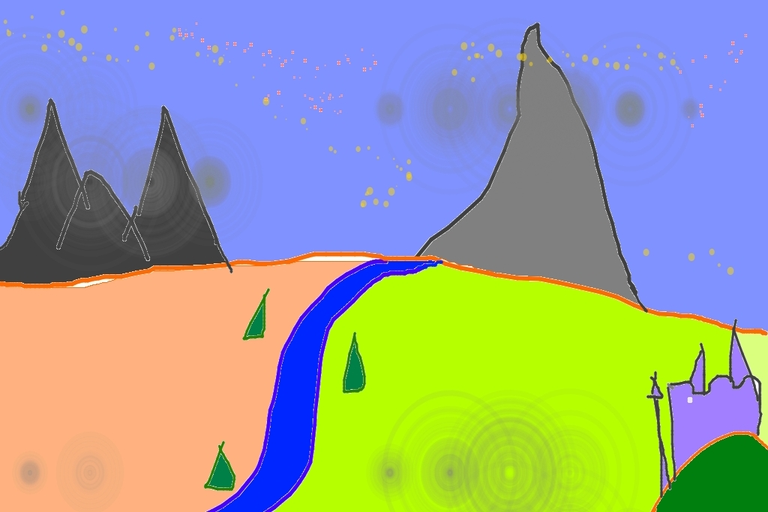

In [5]:
# 风景图草图链接
url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

# 使用requests包获取草图, 输入为风景图草图链接
response = requests.get(url)

# 使用Image包读取风景图草图，并将其转换为"RGB"格式
init_image = Image.open(BytesIO(response.content)).convert("RGB")

# 调整草图尺寸
init_image = init_image.resize((768, 512))
init_image


#### 2.1.3 调用Stable Diffusion模型生成图

第二步：将草图作为输入给Stable Diffusion模型，同时给出提示指令（Prompt）:`"artstation 上流行的奇幻风景"`

  0%|          | 0/37 [00:00<?, ?it/s]

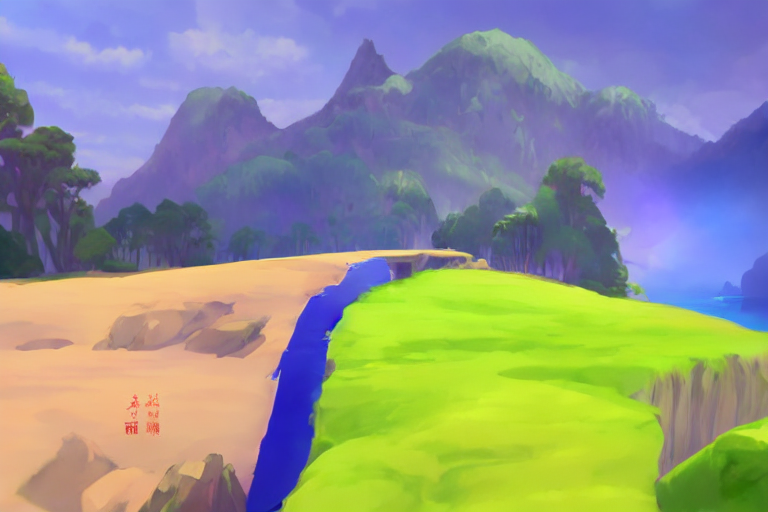

In [6]:
# 给出提示指令，你想要的的图像效果
Prompt = "ArtStation 上流行的奇幻风景"

# 将提示指令(Prompt)和初始图像/草图（init_image）传入模型pipeline
images = pipe(prompt=Prompt, image=init_image, strength=0.75, guidance_scale=7.5).images

# 保存图像到本地
images[0].save("fantasy_landscape.png")

# 显示图像
images[0]

### 2.2 风格迁移：Ghibli风格奇幻风景图

刚刚的例子中我们使用[runwayml/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5)获得ArtStation上流行的奇幻风景图。接下来，我们使用不同的提示尝试获得Ghibli风格带有castles的奇幻风景。

  0%|          | 0/37 [00:00<?, ?it/s]

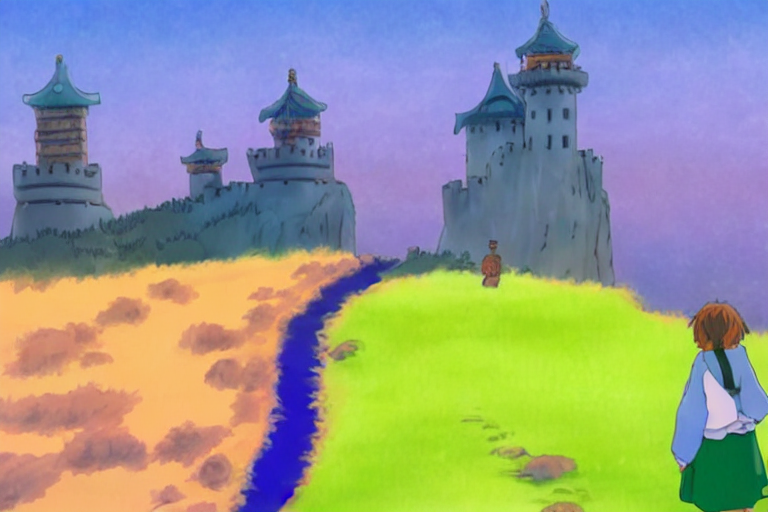

In [7]:
prompt = "Ghibli style, 带有castles的奇幻风景"
generator = torch.Generator(device=device).manual_seed(1024)
image = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5, generator=generator).images[0]
image

 #### 2.2.1 加载Stable Diffusion 模型
上面的模型得到了Ghibli风格带有castles的奇幻风景。但是出来的效果没有很好。[nitrosocke/Ghibli-Diffusion](https://huggingface.co/nitrosocke/Ghibli-Diffusion)模型为基于在Ghibli的现代动画电影中的图像集合上微调的模型。该模型能够更好生成Ghibli风格的图像

In [11]:
device = "cuda"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "nitrosocke/Ghibli-Diffusion", torch_dtype=torch.float16, use_safetensors=True
).to(device)


#### 2.2.3 调用模型生成图像

  0%|          | 0/37 [00:00<?, ?it/s]

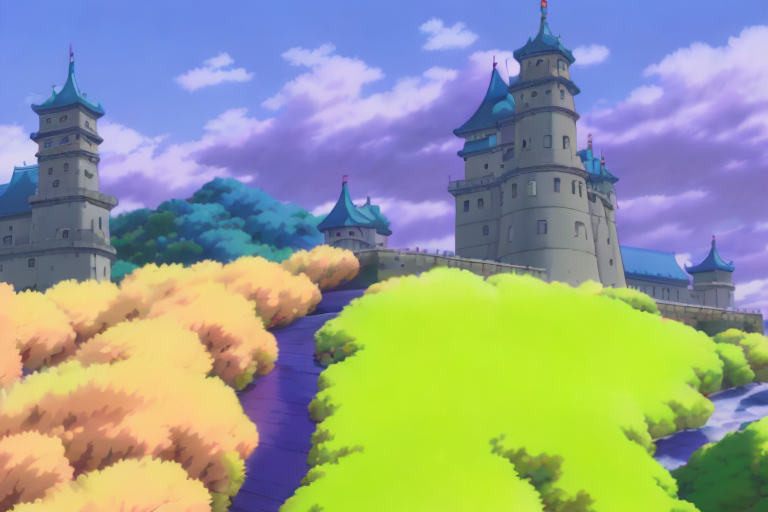

In [9]:
prompt = "Ghibli style, 带有castles的奇幻风景"
generator = torch.Generator(device=device).manual_seed(1024)
image = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5, generator=generator).images[0]
image

可以看到基于Ghibi风格图像微调过的模型在生成Ghibi风格图像的表现上更好。

### 2.3 图像编辑

 #### 2.3.1 加载Stable Diffusion 模型

In [39]:
import PIL
import requests
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler

model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)
pipe.to("cuda")
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

#### 2.3.2 原图

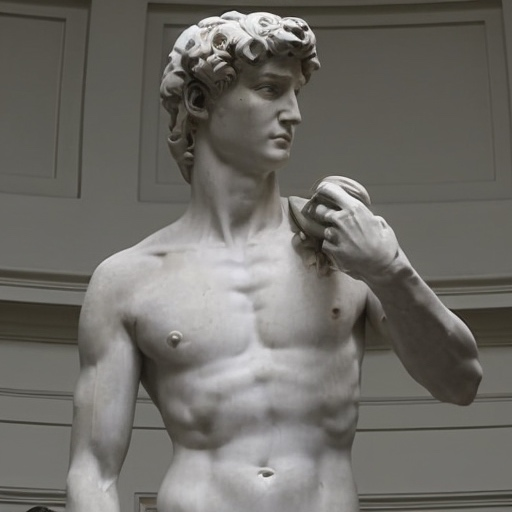

In [41]:
url = "https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/example.jpg"
def download_image(url):
    image = PIL.Image.open(requests.get(url, stream=True).raw)
    image = PIL.ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    return image
image = download_image(url)
image

#### 2.3.3 编辑后的图像

  0%|          | 0/10 [00:00<?, ?it/s]

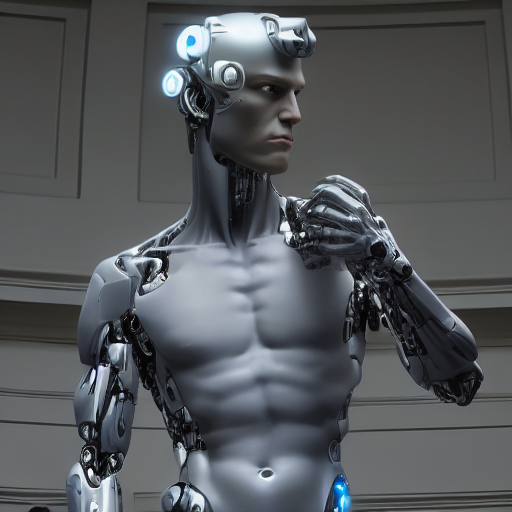

In [42]:
prompt = "turn him into cyborg"
images = pipe(prompt, image=image, num_inference_steps=10, image_guidance_scale=1).images
images[0]


## Todo
- StableDiffusionXLImg2ImgPipeline